In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler

import os

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from model import BertForTokenClassification
import utils.NERutils as nu

from transformers import AutoConfig, AutoTokenizer

print("Imports loaded")


N_EPOCHS = 3
LEARNING_RATE = 1e-05
BATCH_SIZE = 10

# Define tokenizer
bert_model_name = "bert-base-multilingual-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

softmax = nn.Softmax()

train_path = "data/BIOtrain.parquet"
dev_path = "data/BIOdev.parquet"
test_path = "data/BIOtest.parquet"



filters = [ 'Conversation',
            'Legal',
            'News',
            'Social Media',
            'Web',
            'Wiki & Books',]

filter = filters[0]

/Users/joke/anaconda3/envs/NLP2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports loaded


In [2]:
train_dataset = nu.NERdataset(dataset_path=train_path, tokenizer=bert_tokenizer, filter=filter)
dev_dataset = nu.NERdataset(dataset_path=dev_path, tokenizer=bert_tokenizer)
test_dataset = nu.NERdataset(dataset_path=test_path, tokenizer=bert_tokenizer, filter=filter)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, sampler= SubsetRandomSampler(range(100)))
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# Config
bert_model_name = "bert-base-multilingual-cased"
bert_config = AutoConfig.from_pretrained(
    bert_model_name, 
    num_labels=len(train_dataset.tags), 
    id2label=train_dataset.index2tag, 
    label2id=train_dataset.tag2index
)

model = BertForTokenClassification.from_pretrained(bert_model_name, config=bert_config, tags=train_dataset.tags, verbose=True).to(device)
print("Loaded Model")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Model


In [3]:
def toSpans(tags):
    spans = set()
    for beg in range(len(tags)):
        if tags[beg][0] == 'B':
            end = beg
            for end in range(beg+1, len(tags)):
                if tags[beg][0] != 'I':
                    break
            spans.add(str(beg) + '-' + str(end) + ':' + tags[beg][2:])
    return spans

In [4]:
def getF1ScoreFromLists(golds:list, preds: list):
    tp = 0
    fp = 0
    fn = 0
    for goldEnt, predEnt in zip(golds, preds):
        goldSpans = toSpans(goldEnt)
        predSpans = toSpans(predEnt)
        overlap = len(goldSpans.intersection(predSpans))
        tp += overlap
        fp += len(predSpans) - overlap
        fn += len(goldSpans) - overlap
        
    prec = 0.0 if tp+fp == 0 else tp/(tp+fp)
    rec = 0.0 if tp+fn == 0 else tp/(tp+fn)
    f1 = 0.0 if prec+rec == 0.0 else 2 * (prec * rec) / (prec + rec)
    return f1

In [5]:
def get_score_tuples(token_ids, sentence_ids, mask, target, logits):
    res = []
    for token_ids, sentence_id, mask, target, logits in zip(token_ids, sentence_ids, mask, target, logits):
            for word_idx, (token, mask, target, logits) in enumerate(zip(token_ids, mask, target, logits)):
                if mask:
                    # print(torch.argmax(logits).item() == target.item())
                    # print(sentence_id.cpu().item(), word_idx, softmax(logits)[target].cpu().item())
                    res.append({
                        "SentenceID" : sentence_id.cpu().item(),
                        "WordIndex" : word_idx,
                        "Word" : token.item(),
                        "Target" : target.item(),
                        "Correct" : int(torch.argmax(logits).item() == target.item()),
                        "Confidence" : softmax(logits)[target].cpu().item(),
                    })
    return res

In [6]:
def train_loop(model, data_loader, device, optimizer):
    model.train()

    # Initialize parameters for calculating training loss and accuracy
    num_batches = len(data_loader)
    size = len(data_loader.dataset)
    epoch_loss, correct = 0, 0

    for idx, batch in enumerate(data_loader):
        ids = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)
        targets = batch["labels"].to(device, dtype=torch.long)
        
        outputs = model.forward(input_ids = ids,
                        attention_mask = mask,
                        labels = targets)
        
        loss, tr_logits = outputs.loss, outputs.logits


        # Flatten targets and predictions
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # Mask predictions and targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        masked_targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate train loss and accuracy
        epoch_loss += loss.item()
        correct += (masked_targets == predictions).type(torch.float).sum().item()
    
    # Caluclate training loss and accuracy for the current epoch
    train_loss = epoch_loss/num_batches
    train_acc = correct/size
    
    # Save loss and accuracy to history
    # self.training_loss.append(train_loss)
    # self.training_acc.append(train_acc)

In [7]:
def val_loop(model, data_loader, device):
    model.eval()
    epoch_scores = []


    # Initialize parameters for calculating training loss and accuracy
    num_batches = len(data_loader)
    size = len(data_loader.dataset)
    epoch_loss, correct = 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            
            ids = batch["input_ids"].to(device, dtype=torch.long)
            mask = batch["attention_mask"].to(device, dtype=torch.long)
            targets = batch["labels"].to(device, dtype=torch.long)
            
            outputs = model.forward(input_ids = ids,
                            attention_mask = mask,
                            labels = targets)
            
            # Save validation loss
            loss, tr_logits = outputs.loss, outputs.logits

            # Save scores with eval mode
            outputs = model.forward(input_ids = ids,
                                attention_mask = mask,
                                labels = targets)
                
            loss, tr_logits = outputs.loss, outputs.logits
            epoch_scores.extend(get_score_tuples(ids, batch["index"], mask, targets, tr_logits))


            # Flatten targets and predictions
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # Mask predictions and targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
    
            # Calculate train loss and accuracy
            epoch_loss += loss.item()
            correct += (targets == predictions).type(torch.float).sum().item()
    
    # Caluclate training loss and accuracy for the current epoch
    val_loss = epoch_loss/num_batches
    val_acc = correct/size
    
    # Save loss and accuracy to history
    model.validation_loss.append(val_loss)
    model.validation_acc.append(val_acc)
    return pd.DataFrame(epoch_scores)

In [8]:
optimizer=torch.optim.Adam(params=model.parameters(),)
correct_list = []
confidence_list = []

# for epoch in tqdm(range(N_EPOCHS)):
#     train_loop(model, train_loader, device, optimizer)


for epoch in tqdm(range(N_EPOCHS)):

    print(f"Epoch {epoch+1} of {N_EPOCHS} epochs")
    
    print("Train")
    train_loop(model, train_loader, device, optimizer)
    epoch_df = val_loop(model, train_loader, device)
    epoch_df.sort_values(by = ["SentenceID",  "WordIndex"])

    correct_list.append(epoch_df["Correct"])
    confidence_list.append(epoch_df["Confidence"])

print("Done!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
  0%|          | 0/3 [00:00<?, ?it/s]=(true | false)S_PARALLELISM


Epoch 1 of 3 epochs
Train


/Users/joke/anaconda3/envs/NLP2024/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 33%|███▎      | 1/3 [00:33<01:07, 33.64s/it]

Epoch 2 of 3 epochs
Train


 67%|██████▋   | 2/3 [01:07<00:33, 33.52s/it]

Epoch 3 of 3 epochs
Train


100%|██████████| 3/3 [01:41<00:00, 33.86s/it]

Done!


In [10]:
correct = np.array(correct_list).sum(axis = 0) / N_EPOCHS

confidence_list = np.array(confidence_list)
confidence_list[np.isnan(confidence_list)] = 0

confidence_var = np.array(confidence_list).var(axis = 0)
confidence_avg = np.array(confidence_list).mean(axis = 0)

tokens = bert_tokenizer.convert_ids_to_tokens(epoch_df["Word"])
# print(tokens)

df = epoch_df
df["Tokens"] = tokens
df["Correct"] = correct
df["Confidence"] = confidence_avg
df["Variation"] = confidence_var

df["Domain"] = filter
# df.to_csv(f"datamap/test/{filter}.csv")

In [11]:
import seaborn as sns

In [18]:
df_tags = df[df["Target"] != 0]

<Axes: xlabel='Variation', ylabel='Confidence'>

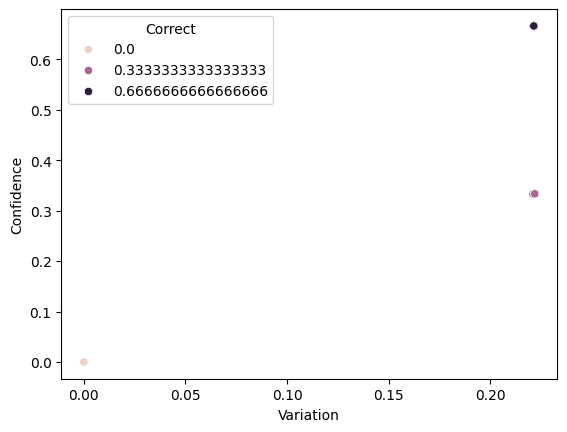

In [19]:
sns.scatterplot(df_tags, x = "Variation", y = "Confidence", hue = "Correct")